# Projeto Final - Análise de Gols em uma Partida de Futebol
Autor: Paulo Victor Lima |   Orientador : Sergio Lima Netto |    Universidade Federal do Rio de Janeiro - Escola Politécnica - Departamente de Engenharia Eletrônica e de Computação

## Importação das Bibliotecas

In [2]:
# #Instalação das bibliotecas

# !pip install pandas
# # !pip install numpy
# # !pip install seaborn
# # !pip install matplotlib.pyplot
# # !pip install plotly.express
# # !pip install glob
# !pip install yellowbrick

In [2]:
#Importação das bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from numpy import loadtxt
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import confusion_matrix
import time
from IPython.display import clear_output




## Importação Base de Dados

### Set Config

Classe set_config()

In [4]:
class set_config():
    def __init__(self, match_generic_path, highlights_file_name):

        #Carrega as features a serem consideradas
        features_types = []
        features_types = loadtxt("..\config\Features_Types.dat", comments="#", delimiter='\n', dtype=str, ndmin=1)
        self.features_types = features_types

        ## Caminho padrão das partidas
        self.match_generic_path = match_generic_path

        # Nome Padrão arquivo "Highlights"
        self.highlights_file_name = highlights_file_name

set_config() para treinamentos

In [5]:
def set_config_treinamento():
    
        match_generic_path = '..\\database\\Treinamento\\**\\'

        highlights_file_name = 'highlights.csv'
        
        return set_config(match_generic_path, highlights_file_name)

set_config() para testes

In [6]:
def set_config_teste():
    
        match_generic_path = '..\\database\\Teste\\**\\'

        highlights_file_name = 'highlights.csv'
        
        return set_config(match_generic_path, highlights_file_name)

set_config() para todas as partidas

In [7]:
def set_config_Aux():
    
        match_generic_path = '..\\database\\Teste_e_Treinamento\\**\\'

        highlights_file_name = 'highlights.csv'
        
        return set_config(match_generic_path, highlights_file_name)

### Leitura Base de Dados

Definição das Funções de leitura da base de dados

In [8]:
def import_moments_classifictaion(match, len, highlights_file_name):
    
    #Caminho para os arquivos de features
    match_by_feature_path = match + highlights_file_name

    #Data frame com todos os intervalos de highligths de uma partida
    highlights_file =  pd.DataFrame()

    #nome das colunas do frame de highlights
    colnames=['first_frame','last_frame', 'classification'] 

    #Data Frame com todos os highlights de uma partida
    highlights_file = pd.read_csv(match_by_feature_path, names=colnames, index_col=None, sep =',', header=None)

    #Data frame com os intervalos de highligths de uma partida
    highlights_of_match = pd.DataFrame(list(range(1,len)), columns=['classification_perigo'], index=list(range(1,len)))

    highlights_of_match['classification_perigo'] = np.nan
    highlights_of_match['classification_gol'] = highlights_of_match['classification_perigo']
    highlights_of_match['classification'] = highlights_of_match['classification_perigo']

    
    for index,row in highlights_file.iterrows():        
        first_frame = int(row['first_frame']) if int(row['first_frame']) != ' ' else 0
        last_frame = int(row['last_frame']) if row['last_frame'] != ' ' else int(row['first_frame'])
        classification_perigo = 'Perigo' if (row['classification'] == ' Gol' or row['classification'] == 'Perigo' or row['classification'] == 'Muito Perigo' ) else 'Normal'
        classification_gol = 'Perigo' if row['classification'] == ' Gol' else 'Não Gol'
        # classification = row['classification'] if row['classification'] != ' Gol' else np.nan ##if (row['classification'] == 'Normal' or row['classification'] == ' Perigo' or row['classification'] == ' Muito Perigo' ) else np.nan
        classification = 'Gol' if row['classification'] == ' Gol' else 'Não Gol' if (row['classification'] == 'Normal' or row['classification'] == ' Perigo' or row['classification'] == ' Muito Perigo' ) else np.nan

        highlights_of_match.loc[first_frame:last_frame, ['classification_gol','classification_perigo', 'classification']] = [classification_gol,classification_perigo, classification]
        # highlights_of_match.loc[first_frame:last_frame, 'classification_gol'] = classification_gol
        
    return highlights_of_match


In [9]:
def import_database (set_config):

    from numpy import loadtxt

    #Carrega as features a serem consideradas
    features_types = []
    features_types = loadtxt("..\config\Features_Types.dat", comments="#", delimiter='\n', dtype=str, ndmin=1)

    ## Caminho padrão das partidas
    match_generic_path = set_config.match_generic_path

    #Lista de partidas existentes na base
    all_matches = glob.glob(match_generic_path, recursive = False)

    ## Data Frame com todos os momementos de todas as partidas
    all_moments = pd.DataFrame()
    ## Array de Data Frames com todos os Data Frames das partidas
    all_moments_array = []

    for match in all_matches:
        print(match)

        #Data frame com todos os momentos de uma partida
        moments_of_match=  pd.DataFrame()

        for feature in features_types:

            #Caminho para os arquivos de features
            match_by_feature_path = match + feature

            #Data Frame com todos os momentos de uma partida de uma feature especifica
            moments_of_match[feature] = pd.read_csv(match_by_feature_path, index_col=None, sep ='\n', thousands=r".", header=None)
        
        #Preenche a coluna 'Match' com a partida
        moments_of_match['Match'] = [match_by_feature_path.split('\\')[-2] for _ in range(len(moments_of_match[feature]))]

        moments_of_match[['Classification_Gol','Classification_Perigo', 'Classification']] = import_moments_classifictaion(match, len(moments_of_match[feature]), set_config.highlights_file_name)  
        # moments_of_match['Classification'] = import_moments_classifictaion(match, len(moments_of_match[feature]), set_config.highlights_file_name)

        moments_of_match.dropna(axis=0, how='any',inplace=True)

        #Adiciona ao array de Data Frames o Data Frame gerado para a partida
        all_moments_array.append(moments_of_match)

    all_moments = pd.concat(all_moments_array,  sort=False, axis=0, ignore_index=True)


    all_moments.to_csv( set_config.match_generic_path.split('\\')[-3] + "moments.csv", index=False, sep=';')
    print(set_config.match_generic_path.split('\\')[-3] + "moments.csv")

    return all_moments

    

## Divisão Previsores e Classe

Previsores

In [10]:
def get_predictors(all_moments, last_column_name):
    return all_moments.loc[:, :last_column_name].values

Classes

In [11]:
def get_classes_perigo(all_moments):
    return all_moments.iloc[:, -1:].values

In [12]:
def get_classes_gol(all_moments):
    return all_moments.iloc[:, -2:-2].values

## Função Principal

In [13]:
def get_Results(group_name):
    df_results = pd.DataFrame()
    for N in range(1,2):
        
        ##Cria o Random Forest e realiza o treinamento
        print('Valor de N: %d ' % (N))
        start_time = time.time()
        random_forest = RandomForestClassifier(n_estimators=N,criterion='entropy',random_state=0, class_weight="balanced")
        random_forest.fit(predictors_treinamento, classes_treinamento)


        predictions = random_forest.predict(predictors_teste)
    
        duration = round(time.time() - start_time, 2)

        result = confusion_matrix(classes_teste,predictions).ravel()

        result = np.append(result, duration)
        result = np.append(accuracy_score(classes_teste, predictions), result)
        result = np.append(result, N)
        result = np.append(result, group_name)
        df_result = pd.DataFrame(result).transpose()
        df_result.columns = ["Assertividade Total", "Verdadeiro Positivo","Falso Negativo","Falso Positivo","Verdadeiro Negativo","Tempo(s)", "N", "Grupo"]
        df_results = pd.concat([df_results, df_result], axis=0, ignore_index=True)

    return df_results[["Assertividade Total", "Verdadeiro Positivo","Verdadeiro Negativo","Falso Positivo","Falso Negativo","Tempo(s)",  "N", "Grupo"]]


In [14]:
# Configurações Gerais de Treinamento
set_config_treinamento = set_config_treinamento()

# Configurações Gerais de Teste
set_config_teste = set_config_teste()

############################################################################################

# Importa a base de dados
all_moments_treinamento = pd.DataFrame()
all_moments_treinamento = import_database(set_config_treinamento)

# Importa a base de dados
all_moments_teste = pd.DataFrame()
all_moments_teste = import_database(set_config_teste)

###########################################################################################

grupo1 = "..\config\Grupos\Grupo1.dat"
grupo2 = "..\config\Grupos\Grupo2.dat"
grupo3 = "..\config\Grupos\Grupo3.dat"
grupo4 = "..\config\Grupos\Grupo4.dat"
grupo5 = "..\config\Grupos\Grupo5.dat"
grupo6 = "..\config\Grupos\Grupo6.dat"
grupo7 = "..\config\Grupos\Grupo7.dat"
grupo8 = "..\config\Grupos\Grupo8.dat"
grupo9 = "..\config\Grupos\Grupo9.dat"

# feature_group_paths = [grupo1,grupo2,grupo3,grupo4,grupo5,grupo6,grupo7,grupo8,grupo9]
feature_group_paths = [grupo1]


final_result = pd.DataFrame()
for feature_group_path in feature_group_paths:
    clear_output(wait=True)
    group_name = feature_group_path.split('\\')[-1].replace(".dat", "")
    print(group_name)
    
    feature_group = loadtxt(feature_group_path, comments="#", delimiter='\n', dtype=str, ndmin=1)
    
    # Separa Preditores e Classificadores
    predictors_treinamento = get_predictors(all_moments_treinamento, feature_group[-1])
    classes_treinamento = get_classes_perigo(all_moments_treinamento)

    ############ TESTE ##########

    # Separa Preditores e Classificadores
    predictors_teste = get_predictors(all_moments_teste, feature_group[-1])
    classes_teste = get_classes_perigo(all_moments_teste)

####################################### GERAR CSV DE RESULTADOS ################################


    group_name = feature_group_path.split('\\')[-1].replace(".dat", "")
    print(group_name)
    group_result = get_Results(group_name)
    final_result = pd.concat([final_result, group_result], axis=0, ignore_index=True)



    

Grupo1
Grupo1
Valor de N: 1 


C:\Users\pv019\AppData\Local\Temp/ipykernel_16016/1730204969.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(predictors_treinamento, classes_treinamento)


In [15]:
# final_result.to_csv( "..\\..\\Resultados Modelo\\RESULTADO-FINAL.csv", index=False, sep=';')


C:\Users\pv019\AppData\Local\Temp/ipykernel_16016/3210277410.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(predictors_treinamento, classes_treinamento)


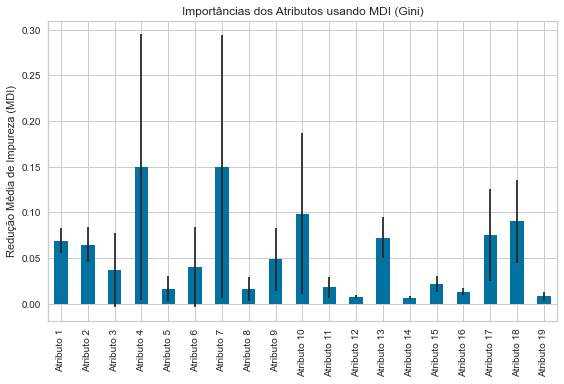

: 

In [21]:

##############Verificar importancia das features######################
from cProfile import label


random_forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0)
random_forest.fit(predictors_treinamento, classes_treinamento)

importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index= ['Atributo 1','Atributo 2','Atributo 3','Atributo 4','Atributo 5','Atributo 6','Atributo 7','Atributo 8','Atributo 9','Atributo 10','Atributo 11','Atributo 12','Atributo 13','Atributo 14','Atributo 15','Atributo 16','Atributo 17','Atributo 18','Atributo 19'])


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importâncias dos Atributos usando MDI (Gini)")
ax.set_ylabel("Redução Média de Impureza (MDI)")
fig.tight_layout()

## Análises Auxiliares

In [17]:
# # Configurações Gerais de Treinamento
# set_config_treinamento = set_config_Aux()

# all_moments = import_database(set_config_treinamento)
# sns.set(rc={'figure.figsize':(10.2,8.27)})
# fig = sns.countplot(y="Classification", hue="Match", data = all_moments, palette="tab10")

# fig.set_xlabel("Quantidade")
# fig.set_ylabel("Classificação")

# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


In [18]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# fig = sns.countplot(y="Classification", data = all_moments)
# fig.set_xlabel("Quantidade")
# fig.set_ylabel("Classificação")

<AxesSubplot:>

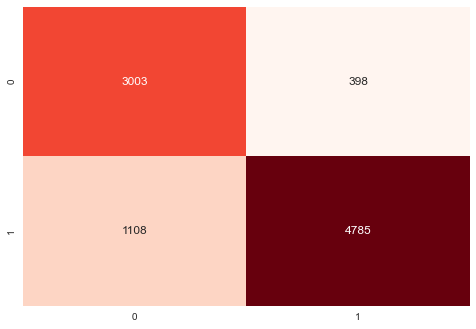

In [8]:
from pickle import FALSE

# entropia_direto = [[3017, 513], [1200, 18085]]# sns.heatmap(entropia_direto, annot=True, cmap='Reds', cbar=False, fmt='d')
# # #####################################################################
# Gini_direto = [[3003, 509], [1214, 18089]]# sns.heatmap(Gini_direto, annot=True, cmap='Reds', cbar=False, fmt='d')

# #####################################################################
# entropia_primeiro = [[2964, 474], [1253, 18124]]# sns.heatmap(entropia_primeiro, annot=True, cmap='Reds', cbar=False, fmt='d')

# entropia_segundo = [[18083, 8], [41, 2956]]# sns.heatmap(entropia_segundo, annot=True, cmap='Reds', cbar=False, fmt='d')
# ########################################################################
# gini_primeiro = [[2948, 468], [1269, 18130]]# sns.heatmap(gini_primeiro, annot=True, cmap='Reds', cbar=False, fmt='d')

	

gini_segundo = [[3003,	398], [1108,	4785]]
sns.heatmap(gini_segundo, annot=True, cmap='Reds', cbar=False, fmt='d')